In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

import tensorflow as tf

import gpflow
from gpflow.utilities import read_values, multiple_assign, set_trainable
from gpflow.inducing_variables import InducingPoints
import gpmaniflow
from gpmaniflow.models.SVGP import SVGP

import gpmaniflow.samplers
from gpmaniflow.samplers import initialize_sampler
from gpmaniflow.curves import BezierCurve

In [2]:
pX = np.reshape(np.random.uniform(-2, 2, 200*2), [200, 2])
X = np.random.uniform(-3, 3, 200*2)[:, None]
X = np.reshape(X, [200, 2])
Y = 2 * X[:,0] ** 2 + 1 * X[:,1] + np.random.randn(200) * 0.1
Y = np.reshape(Y, [200,1])
Z = np.random.uniform(-3, 3, 60*2)[:, None]
Z = np.reshape(Z, [60, 2])

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
train_dataset = train_dataset.shuffle(1024).batch(len(X))

In [3]:
end_points = np.array([[[0,0]],[[1,1]]])
end_points.shape

c = BezierCurve(end_points)
t = np.linspace(0,1, 50)
print(t)
C = c(t)
print(C)
C.shape

[0.         0.02040816 0.04081633 0.06122449 0.08163265 0.10204082
 0.12244898 0.14285714 0.16326531 0.18367347 0.20408163 0.2244898
 0.24489796 0.26530612 0.28571429 0.30612245 0.32653061 0.34693878
 0.36734694 0.3877551  0.40816327 0.42857143 0.44897959 0.46938776
 0.48979592 0.51020408 0.53061224 0.55102041 0.57142857 0.59183673
 0.6122449  0.63265306 0.65306122 0.67346939 0.69387755 0.71428571
 0.73469388 0.75510204 0.7755102  0.79591837 0.81632653 0.83673469
 0.85714286 0.87755102 0.89795918 0.91836735 0.93877551 0.95918367
 0.97959184 1.        ]
tf.Tensor(
[[0.         0.        ]
 [0.02040816 0.02040816]
 [0.04081633 0.04081633]
 [0.06122449 0.06122449]
 [0.08163265 0.08163265]
 [0.10204082 0.10204082]
 [0.12244898 0.12244898]
 [0.14285714 0.14285714]
 [0.16326531 0.16326531]
 [0.18367347 0.18367347]
 [0.20408163 0.20408163]
 [0.2244898  0.2244898 ]
 [0.24489796 0.24489796]
 [0.26530612 0.26530612]
 [0.28571429 0.28571429]
 [0.30612245 0.30612245]
 [0.32653061 0.32653061]
 [0.3

TensorShape([50, 2])

In [4]:
kernel = gpflow.kernels.SquaredExponential()

model = SVGP(kernel, likelihood = gpflow.likelihoods.Gaussian(), inducing_variable=InducingPoints(Z.copy()))

train_iter = iter(train_dataset.repeat())
training_loss = model.training_loss_closure(train_iter, compile=True)
optimizer = tf.keras.optimizers.Adam(0.01)
@tf.function
def optimization_step():
    optimizer.minimize(training_loss, model.trainable_variables)
elbo_hist = []
for step in range(3000):
    optimization_step()
    if step % 50 == 0:
        minibatch_elbo = -training_loss().numpy()
        print('Step: %s, Mini batch elbo: %s' % (step, minibatch_elbo))
        elbo_hist.append(minibatch_elbo)

ELBO = model.elbo((X,Y))

Step: 0, Mini batch elbo: -5539.464605420023
Step: 50, Mini batch elbo: -3242.7635066771495
Step: 100, Mini batch elbo: -1812.3851961458868
Step: 150, Mini batch elbo: -1051.216632356912
Step: 200, Mini batch elbo: -706.6347370943862
Step: 250, Mini batch elbo: -560.3199076546014
Step: 300, Mini batch elbo: -500.5387948252319
Step: 350, Mini batch elbo: -472.35286330547933
Step: 400, Mini batch elbo: -456.57596188310055
Step: 450, Mini batch elbo: -445.51865782788116
Step: 500, Mini batch elbo: -437.2513331492288
Step: 550, Mini batch elbo: -430.73741873463916
Step: 600, Mini batch elbo: -425.1170928883988
Step: 650, Mini batch elbo: -420.2645716448386
Step: 700, Mini batch elbo: -415.85872869213034
Step: 750, Mini batch elbo: -411.7423522791935
Step: 800, Mini batch elbo: -407.8945767758198
Step: 850, Mini batch elbo: -404.24805029710586
Step: 900, Mini batch elbo: -400.6320489644879
Step: 950, Mini batch elbo: -397.1744746152081
Step: 1000, Mini batch elbo: -393.832857672213
Step: 10

In [9]:
model.MatheronSampler = initialize_sampler(from_df = True)

I'm here
(60, 60)


In [10]:
J = model.MatheronSampler(C)
J.shape

(1, 1, 50, 2)
(100, 60)
tf.Tensor(
[[ 4.42994221e-03 -8.12582073e-02 -2.63887412e+00 ... -1.20832905e+00
   2.16095293e+00 -1.47078815e+00]
 [ 2.79324154e-03 -3.27147891e+00 -1.83933217e+00 ...  1.31890885e+00
  -1.24870959e+00  7.00799290e-01]
 [ 4.71057577e-03 -1.15508044e-01 -2.64474158e+00 ... -1.22086458e+00
   2.15639982e+00 -1.46488694e+00]
 ...
 [ 3.46085219e-02 -2.02105192e+00 -1.48215405e+00 ...  6.17782463e-01
  -2.15341562e+00  1.03986189e-01]
 [ 6.48190342e-02 -7.23748820e-01 -1.75466436e+00 ... -1.35921003e+00
   1.26420281e+00 -8.47554849e-01]
 [ 3.61988973e-02 -1.98465979e+00 -1.45904569e+00 ...  6.02094167e-01
  -2.15838818e+00  9.73502332e-02]], shape=(100, 60), dtype=float64)
tf.Tensor(
[[[[-1.46859052]
   [ 4.69295893]
   [-1.32141473]
   [ 4.68378112]
   [-1.17196675]
   [ 4.67253601]
   [-1.02037137]
   [ 4.65923344]
   [-0.86675879]
   [ 4.64388648]
   [-0.71126416]
   [ 4.6265116 ]
   [-0.55402713]
   [ 4.60712875]
   [-0.39519131]
   [ 4.58576153]
   [-0.234903

TensorShape([1, 50, 2, 1])

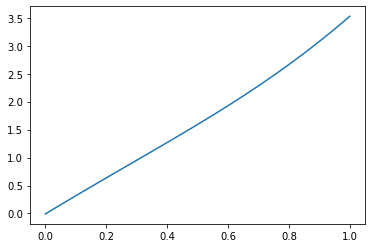

In [11]:
#J = tf.reshape(J, [1, 1, 50, 2])
plt.plot(t, J[0,:,0,0])

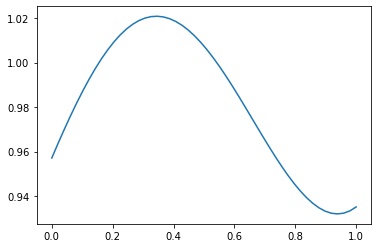

In [12]:
plt.plot(t, J[0,:,1,0])